In [325]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

import collections
import re

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# Implementing a spam classifier

## Read and examine the data

In [71]:
# Define url
archive = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

# Open url
url = urlopen(archive)

In [72]:
# read zip file
my_zip = ZipFile(BytesIO(url.read()))

In [73]:
# Get file names
my_zip.namelist()

['SMSSpamCollection', 'readme']

In [75]:
filename = my_zip.namelist()[0]

In [86]:
# Read in the data
data = pd.read_csv(my_zip.open(filename), sep='\t', header=None, names=['class', 'text'])

In [103]:
data.sample(10)

,class,text
1026,ham,I have a sore throat. It's scratches when I talk
4004,ham,somewhere out there beneath the pale moon ligh...
4810,ham,"Don't worry though, I understand how important..."
532,ham,What Today-sunday..sunday is holiday..so no wo...
5028,spam,PRIVATE! Your 2003 Account Statement for shows...
4129,ham,I dont thnk its a wrong calling between us
1634,ham,Yesterday its with me only . Now am going home.
2232,ham,"K, wen ur free come to my home and also tel vi..."
4683,ham,"Haha yeah, 2 oz is kind of a shitload"
1680,ham,"Today is ""song dedicated day.."" Which song wil..."


In [98]:
def get_sample(data=data, n=10):
    sample = data.sample(n).iloc[:,1]
    for i in sample:
        print(f'{i}\n')

In [102]:
get_sample(n=2)

Yeah like if it goes like it did with my friends imma flip my shit in like half an hour

Yes:)from last week itself i'm taking live call.



## Prepare and pre-process the data

In [123]:
# Binarize labels
data['class'] = data['class'].map({'ham': 0, 'spam': 1})

* ### Train test split

In [124]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], 
                                                   test_size=.25)

In [329]:
# Vectorize X
count_vec = CountVectorizer(min_df=1)

In [330]:
X_train_counts = count_vec.fit_transform(X_train)

In [331]:
X_train_counts

<4179x7463 sparse matrix of type '<class 'numpy.int64'>'
	with 55470 stored elements in Compressed Sparse Row format>

In [332]:
# A quick check of a vocab list
number = np.random.randint(2314)
list(count_vec.vocabulary_.items())[number:number+4]

[('arul', 1029), ('doctor', 2282), ('august', 1082), ('09066660100', 232)]

## Train

In [333]:
# Instantiate NB clf
clf = MultinomialNB()

In [334]:
# Fit our clf
clf.fit(X_train_counts, y_train.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [335]:
len(clf.coef_[0])

7463

In [336]:
importance_count = collections.Counter()

In [337]:
for word, imp in zip(count_vec.vocabulary_.keys(), clf.coef_[0]):
    importance_count[word] = imp

In [338]:
importance_count.most_common()[:10]

[('nz', -3.6553343335941104),
 ('catching', -4.322506027750795),
 ('fired', -4.507027805454352),
 ('casing', -4.5706856572263295),
 ('mus', -4.819990034579211),
 ('chords', -4.882121815686218),
 ('invention', -4.888552706016508),
 ('noworriesloans', -4.928031516990296),
 ('jontin', -4.962164523359754),
 ('shitload', -5.127956778202498)]

## Test

In [339]:
# Transform test 
X_test_counts = count_vec.transform(X_test)

In [340]:
# Predict
preds = clf.predict(X_test_counts)

## Evaluate

In [341]:
# Evaluate
def get_metrics(y_true, y_pred, metric=[f1_score]):
    for m in metric:
        metric_name = s = re.search('\s\S+\s', str(m)).group(0).strip()
        print(f'{metric_name:30}== {m(y_true, y_pred):.4f}')
    print('\n')
    print(classification_report(y_true, y_pred))

In [342]:
get_metrics(y_test, preds, metric=[f1_score, 
                                   average_precision_score,
                                  accuracy_score])

f1_score                      == 0.9584
average_precision_score       == 0.9269
accuracy_score                == 0.9892


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1209
          1       0.98      0.94      0.96       184

avg / total       0.99      0.99      0.99      1393



In [343]:
len(X_train.values)

4179

In [344]:
len(X_test.values)

1393

In [345]:
# Some snity check

def predict_random(test_set):
    phrase = test_set.values[np.random.randint(len(test_set))]
    pred = clf.predict(count_vec.transform([phrase]))
    if pred == 1:
        pred = 'SPAM'
    else:
        pred = 'HAM'
    return phrase, pred

In [346]:
def make_preds(test_set, n):
    for i in range(n):
        pred = predict_random(test_set)
        print(f'Message:\n{pred[0]}\nClass: {pred[1]}\n')

In [347]:
make_preds(X_test, 10)

Message:
Draw va?i dont think so:)
Class: HAM

Message:
Thanks, I'll keep that in mind
Class: HAM

Message:
K, jason says he's gonna be around so I'll be up there around  &lt;#&gt;
Class: HAM

Message:
Yo, call me when you get the chance, a friend of mine wanted me to ask you about a big order
Class: HAM

Message:
Dunno lei shd b driving lor cos i go sch 1 hr oni.
Class: HAM

Message:
Hmmm...k...but i want to change the field quickly da:-)i wanna get system administrator or network administrator..
Class: HAM

Message:
74355 XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC
Class: SPAM

Message:
I sent lanre fakeye's Eckankar details to the mail box
Class: HAM

Message:
Eh u remember how 2 spell his name... Yes i did. He v naughty make until i v wet.
Class: HAM

Message:
We will meet soon princess! Ttyl!
Class: HAM



In [348]:
# Confusion matrix
mtrx = confusion_matrix(y_test, preds)

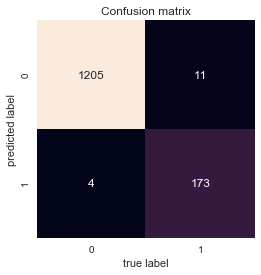

In [349]:
sns.heatmap(mtrx.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()

In [353]:
mtrx

array([[1205,    4],
       [  11,  173]], dtype=int64)

In [355]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()